In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import shutil

In [3]:
def get_parameters():
    params = {
        'img_height': 128,
        'img_width': 128,
        'batch_size': 16,
        'epochs': 20,
        'learning_rate': 0.0005,
        'base_dir': '/home/yvan/Escritorio/Acustic/img/Prueba',
        'balanced_dir': '/home/yvan/Escritorio/Acustic/img/Prueba_balanced',
        'num_images_per_class': 1700  # Número de imágenes por clase
    }
    return params

In [4]:
# Función para crear un conjunto de datos balanceado
def create_balanced_dataset(base_dir, target_dir, num_images_per_class):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    class_names = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        images = os.listdir(class_path)
        np.random.shuffle(images)
        images = images[:num_images_per_class]
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        # Crear directorios para entrenamiento y validación
        train_class_dir = os.path.join(target_dir, 'train', class_name)
        val_class_dir = os.path.join(target_dir, 'val', class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        # Copiar las imágenes a los nuevos directorios
        for img in train_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(train_class_dir, img)
            shutil.copyfile(src, dst)

        for img in val_images:
            src = os.path.join(class_path, img)
            dst = os.path.join(val_class_dir, img)
            shutil.copyfile(src, dst)

    print("Conjunto de datos balanceado creado en", target_dir)

In [5]:
# Función para crear generadores de datos sin usar validation_split
def create_data_generators(train_dir, val_dir, img_height, img_width, batch_size):
    # Aumento de datos para entrenamiento
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    # Solo rescalado para datos de validación
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary'
    )
    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False  # Importante para la evaluación
    )
    return train_generator, validation_generator

# Obtener los parámetros
params = get_parameters()

In [6]:
# Crear conjunto de datos balanceado
create_balanced_dataset(params['base_dir'], params['balanced_dir'], params['num_images_per_class'])

# Crear generadores de datos
train_dir = os.path.join(params['balanced_dir'], 'train')
val_dir = os.path.join(params['balanced_dir'], 'val')

train_generator, validation_generator = create_data_generators(
    train_dir,
    val_dir,
    params['img_height'],
    params['img_width'],
    params['batch_size']
)

# Verificar la distribución de clases
print("Distribución de clases en el conjunto de entrenamiento:")
print(train_generator.class_indices)
print("Distribución de clases en el conjunto de validación:")
print(validation_generator.class_indices)


Conjunto de datos balanceado creado en /home/yvan/Escritorio/Acustic/img/Prueba_balanced
Found 2720 images belonging to 2 classes.
Found 680 images belonging to 2 classes.
Distribución de clases en el conjunto de entrenamiento:
{'(Real) Covid': 0, '(Real) Non-Covid': 1}
Distribución de clases en el conjunto de validación:
{'(Real) Covid': 0, '(Real) Non-Covid': 1}


In [7]:
# Cargar el modelo preentrenado (MobileNetV2)
base_model = MobileNetV2(input_shape=(params['img_height'], params['img_width'], 3),
                         include_top=False,
                         weights='imagenet')

# Congelar el modelo base inicialmente
base_model.trainable = False

# Crear el modelo
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [8]:
# Compilar el modelo
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks para ajustar la tasa de aprendizaje y detener el entrenamiento temprano
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Entrenar el modelo (etapa 1)
history = model.fit(
    train_generator,
    epochs=params['epochs'],
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/20


/home/yvan/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


170/170 ━━━━━━━━━━━━━━━━━━━━ 26s 136ms/step - accuracy: 0.7692 - loss: 0.5899 - val_accuracy: 0.8794 - val_loss: 0.3979 - learning_rate: 5.0000e-04
Epoch 2/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.8931 - loss: 0.3340 - val_accuracy: 0.9118 - val_loss: 0.3135 - learning_rate: 5.0000e-04
Epoch 3/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 25s 145ms/step - accuracy: 0.9244 - loss: 0.2687 - val_accuracy: 0.9235 - val_loss: 0.2641 - learning_rate: 5.0000e-04
Epoch 4/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.9352 - loss: 0.2329 - val_accuracy: 0.9250 - val_loss: 0.2638 - learning_rate: 5.0000e-04
Epoch 5/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.9248 - loss: 0.2359 - val_accuracy: 0.9265 - val_loss: 0.2455 - learning_rate: 5.0000e-04
Epoch 6/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - accuracy: 0.9309 - loss: 0.2302 - val_accuracy: 0.9309 - val_loss: 0.2316 - learning_rate: 5.0000e-04
Epoch 7/20
170/170 ━━━━━━━━━━━━━━━━━━━━ 27s 157ms/step - 

In [9]:
# Descongelar algunas capas del modelo base para fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 50  # Descongelar las últimas 50 capas

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compilar el modelo con una tasa de aprendizaje más pequeña
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']/10),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo (etapa 2)
fine_tune_epochs = 10
total_epochs = params['epochs'] + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 20/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 34s 164ms/step - accuracy: 0.8554 - loss: 0.3696 - val_accuracy: 0.9279 - val_loss: 0.1940 - learning_rate: 5.0000e-05
Epoch 21/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 31s 179ms/step - accuracy: 0.9394 - loss: 0.1877 - val_accuracy: 0.9206 - val_loss: 0.2481 - learning_rate: 5.0000e-05
Epoch 22/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 33s 190ms/step - accuracy: 0.9387 - loss: 0.1773 - val_accuracy: 0.9206 - val_loss: 0.2033 - learning_rate: 5.0000e-05
Epoch 23/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9335 - loss: 0.1802
Epoch 23: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
170/170 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.9335 - loss: 0.1802 - val_accuracy: 0.8971 - val_loss: 0.2655 - learning_rate: 5.0000e-05
Epoch 24/30
170/170 ━━━━━━━━━━━━━━━━━━━━ 33s 188ms/step - accuracy: 0.9320 - loss: 0.1849 - val_accuracy: 0.9059 - val_loss: 0.2637 - learning_rate: 2.5000e-05
Epoch 24: early stopping
Restoring model weigh

In [10]:
# Evaluar el modelo
val_probs = model.predict(validation_generator)
true_labels = validation_generator.classes

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(true_labels, val_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Umbral óptimo: {optimal_threshold:.4f}")

# Usar el umbral óptimo para las predicciones
val_predictions = (val_probs >= optimal_threshold).astype(int)

43/43 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step
Umbral óptimo: 0.6288


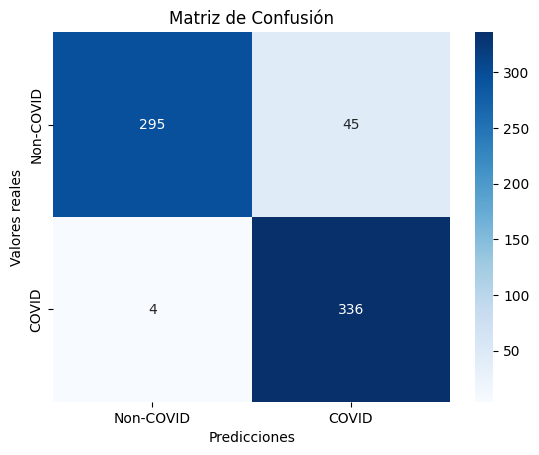

In [11]:
# Generar la matriz de confusión
cm = confusion_matrix(true_labels, val_predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-COVID', 'COVID'],
            yticklabels=['Non-COVID', 'COVID'])
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión")
plt.show()

In [12]:
# Reporte de clasificación
print(classification_report(true_labels, val_predictions, target_names=['Non-COVID', 'COVID']))

              precision    recall  f1-score   support

   Non-COVID       0.99      0.87      0.92       340
       COVID       0.88      0.99      0.93       340

    accuracy                           0.93       680
   macro avg       0.93      0.93      0.93       680
weighted avg       0.93      0.93      0.93       680



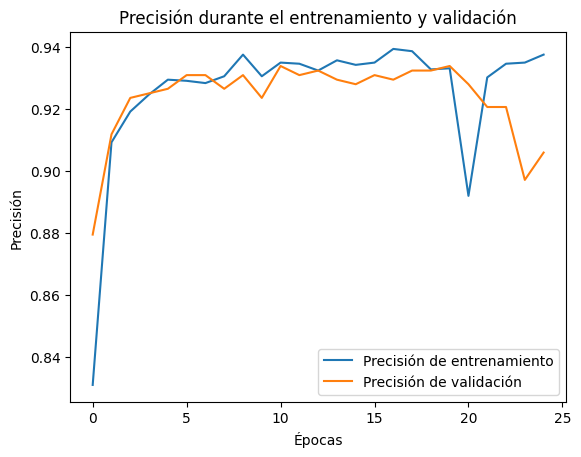

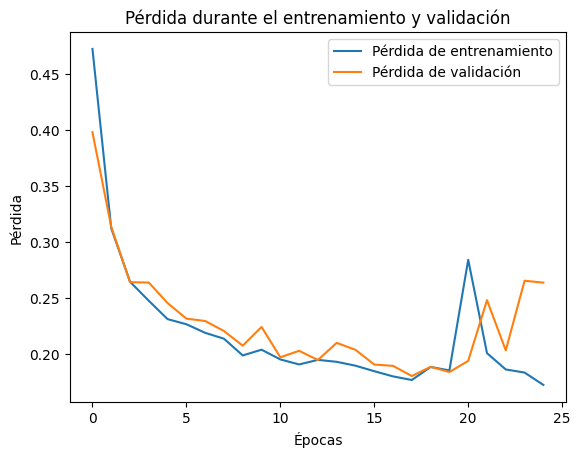

In [13]:
# Gráficos de precisión y pérdida para monitorear el sobreajuste
plt.figure()
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Precisión durante el entrenamiento y validación')

plt.figure()
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title('Pérdida durante el entrenamiento y validación')

plt.show()

##